In [17]:
import numpy as np
import jax
import jax.numpy as jnp
import pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [18]:
data = pd.read_csv("/Users/apple/Desktop/DSA4212/Project 1/songsDataset.csv",header=0, names=['userID','songID','rating'])
data.shape

(2000000, 3)

<AxesSubplot:>

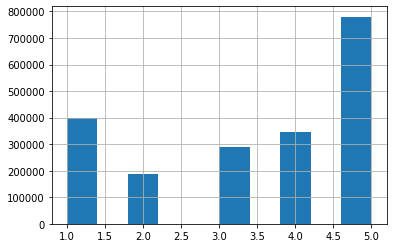

In [19]:
data['rating'].hist()

In [21]:
# Calculate the size of each partition
total_size = len(data)
train_size = total_size * 8 //10  # 80% for training (and make sure the index are integer type not float)
test_size = total_size - train_size  # Remaining 20% for testing
partition_sizes = [train_size // 8] * 8 + [test_size // 2] * 2

# Shuffle the DataFrame rows
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled DataFrame into partitions
partitions = [df_shuffled.iloc[i:i+size] for i, size in enumerate(partition_sizes)]

# Assign partitions to train and test datasets
train_datasets = partitions[:8]
test_datasets = partitions[8:]

In [94]:
# Train dataset
combined_array1 = np.concatenate((train_datasets[0],train_datasets[1],train_datasets[2],train_datasets[3],train_datasets[4],train_datasets[5],train_datasets[6],train_datasets[7]),axis=0)
train_df = pd.DataFrame(combined_array1, columns=['userID','songID','rating'])
train_df.reset_index(drop=True, inplace=True) # Optional: Reset index if you want sequential index

#n_users_train = train_df['userID'].nunique()
#n_songs_train = train_df['songID'].nunique()
#n_ratings_train = train_df.shape[0] #1600000

song_ids = list(train_df['songID'].unique())
train_users = np.copy(train_df['userID'])
train_songs = np.copy(train_df['songID'])
train_ratings = np.copy(train_df['rating'])

# Test dataset
combined_array2 = np.concatenate((test_datasets[0], test_datasets[1]), axis=0)
test_df = pd.DataFrame(combined_array2, columns=['userID','songID','rating'])
test_df.reset_index(drop=True, inplace=True)

song_ids = list(train_df['songID'].unique())
test_users = np.copy(test_df['userID'])
test_songs = np.copy(test_df['songID'])
test_ratings = np.copy(test_df['rating'])

In [85]:
@jax.jit
def loss(U_single,S_single,rating_single):
    pred = jnp.dot(U_single,S_single)
    error = (rating_single-pred)**2
    return error

# loss_grad = jax.jit(jax.grad(loss,argnums=(0,1)))
loss_grad_U = jax.jit(jax.grad(loss, argnums=0))
loss_grad_S = jax.jit(jax.grad(loss, argnums=1))

def mse(U_batch,S_batch,ratings_batch):
    predictions = np.sum(U_batch*S_batch,axis=1)
    errors = (ratings_batch-predictions)**2
    return np.mean(errors)

In [91]:
d_factors = 10
U_init = np.random.normal(3,1,size=(train_df['userID'].max()+1,d_factors))/np.sqrt(d_factors) # 3 is the midpoint of the rating scale 1-5 ???
S_init = np.random.normal(3,1,size=(train_df['songID'].max()+1,d_factors))/np.sqrt(d_factors)

niter = 100
learning_rate = 0.05
U = U_init.copy()
S = S_init.copy()
MSE = []

In [92]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(1600000)
        user_id = train_users[index]
        song_id = train_songs[index]
        rating = train_ratings[index]
        song_index = song_ids.index(song_id)

        U_grad = loss_grad_U(U[user_id],S[song_index],rating)
        S_grad = loss_grad_S(U[user_id],S[song_index],rating)
        U[user_id] -= learning_rate*U_grad
        S[song_index] -= learning_rate*S_grad
        
    if ((i+1)%10==0) | (i==0):
        U_batch = U[:10000]
        song_indices = [song_ids.index(e) for e in train_songs[:10000]]
        V_batch = S[song_indices]
        ratings_batch = train_ratings[:10000]
        mse_current = mse(U_batch,V_batch,ratings_batch)
        MSE.append(mse_current)
        print(f"iter {i+1}, mse={mse_current:.5f}")

iter 1, mse=17.97384
iter 10, mse=6.69267
iter 20, mse=5.04166
iter 30, mse=4.45731
iter 40, mse=4.19457
iter 50, mse=4.04010
iter 60, mse=3.95186
iter 70, mse=3.91253
iter 80, mse=3.87087
iter 90, mse=3.86902
iter 100, mse=3.86348


Text(0.5, 0, 'iteration')

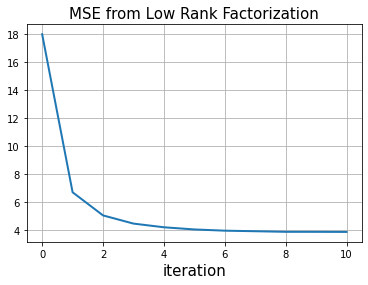

In [93]:
plt.plot(MSE,'-',lw=2)
plt.grid()
plt.title('MSE from Low Rank Factorization',fontsize=15)
plt.xlabel('iteration',fontsize=15)

In [95]:
# Generate predictions
predicted_ratings = []
for user_id, song_id in zip(test_users,test_songs):

    user_embedding = U[user_id]
    song_embedding = S[song_id]

    # Predict the rating using dot product of user and item embeddings
    predicted_rating = np.dot(user_embedding, song_embedding)

    predicted_ratings.append(predicted_rating)

# Evaluate predictions
rmse = np.sqrt(np.mean((predicted_ratings - test_ratings) ** 2))
print("RMSE:", rmse)

RMSE: 3.1847290945031
